# Guess the colourmap from an image

The functions in `unmap.unweave.py` attempt to guess the colourmap from an image, using the graph implied by the colour co-occurrence matrix.

The following things will make things difficult:

- **You don't have a lot of pixels.** Small images are hard to rip data from. We'd always like more pixels.
- **The colourmap is not smooth.** If there are strong colour contrasts in the colourmap, then the algorithm will struggle.
- **The data distribution is not uniform.** (It probably isn't.) This wilkl tend to over-represent certain colours.
- **There are a lot of annotations.** Usually these get in the way of the data, especially if they use colours that also appear in the colourmap.
- **The image is lossily compressed.** Most PDFs contain JPEGs and JPEG is [lossy](https://en.wikipedia.org/wiki/Lossy_compression). This means the colours are a bit garbled, especially around abrupt edges (like annotations!).
- **The image has dithering.** If the number of colours in the image has been reduced at some point, there's a good chance it has been [dithered](https://en.wikipedia.org/wiki/Dither).
- **The image has hillshading or specularity.** Cute 3D effects add another layer of complexity... but we can still have a go. 
- **The image is poor.** If it's a photo or scan of a paper document... well, now you 've got the unknown transform from the data to the image, then the unknown transform of the image to the physical plot, then the unknown transform of the plot to the image you have. I mean, come on.

Finally, if you don't have the colourmap information in a legend, then you may also not know the range of the data. There's nothing you can do about that, unfortunately.

Things we may add in the future:

- Remove hillshade or specularity.
- Selectively remove certain colours. (Right now, colours that are different from anything else in the colourmap will likely be dropped anyway, e.g. black borders, because they are too far from the other colours.)
- Colourbar corrections for, e.g. a Gaussian distribution assumption.
- Match the language between `unmap.py` and `unweave.py`.
- Add a `mask` option so that a person can more easily just focus on the data area.

## Example

Let's try to guess the colourmaps of some images on the web.

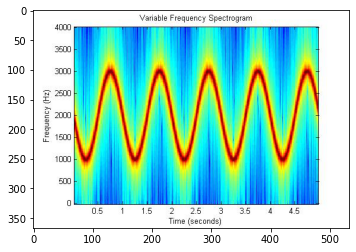

In [8]:
from io import BytesIO

import requests
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


def get_image_from_web(uri):
    data = requests.get(uri).content
    img = Image.open(BytesIO(data)).convert('RGB')
    rgb_im = np.asarray(img)[..., :3] / 255.
    return rgb_im

# Public domain image.
uri = 'https://upload.wikimedia.org/wikipedia/commons/2/2b/VariableFrequency.jpg'
img = get_image_from_web(uri)

plt.imshow(img)

We can give the image URI directly to `guess_cmap()`. It will read the image and try to construct a colourmap from it.

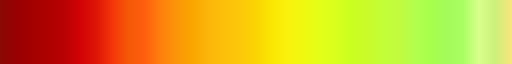

In [9]:
from unmap import guess_cmap

guess_cmap(uri)

We got something, but it missed out the blues. We can try adjusting the maximum (Euclidean) distance allowed between neighbouring colours.

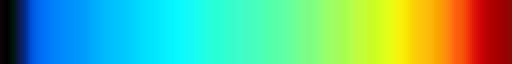

In [27]:
guess_cmap(uri, max_dist=0.4)

We seem to be close; we're getting a lot of blue-green though. The `equilibrate` option might help spread the colourbar out a bit more evenly.

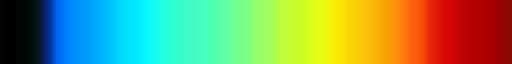

In [23]:
guess_cmap(uri, max_dist=0.4, equilibrate=True)

This helps a little, but sometimes this option can emphasize some abrupt colour boundaries, like the one in the red zone of the one above.

We could now give this colourmap to the unmapper:

In [33]:
from unmap import unmap

cmap = guess_cmap(uri, max_dist=0.4, equilibrate=True)
data = unmap(img, cmap=cmap)

Let's look at the result:

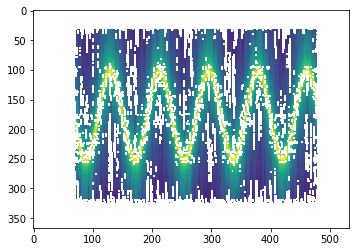

In [34]:
import matplotlib.pyplot as plt

plt.imshow(data)

Too many colours were not mapped, because they are too far from anything in the colourmap. We can relax the threshold a bit:

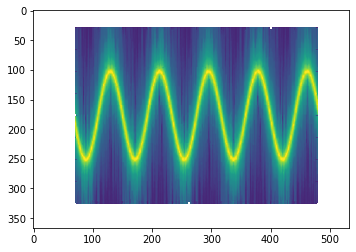

In [36]:
data = unmap(img, cmap=cmap, threshold=0.4)
plt.imshow(data)

This result looks good.

## Compare with the known colourmap

In this case, it looks like the actual colourmap is probably `jet`, let's compare:

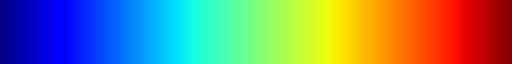

In [37]:
import matplotlib.cm as cm

cm.jet

This is comparable to the result we get when passing the known colourmap, `jet`:

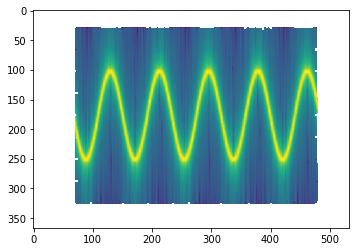

In [40]:
data = unmap(img, cmap='jet', threshold=0.4)

plt.imshow(data)

We don't know the range of the data though, of course.